<a href="https://colab.research.google.com/github/rashidmeras/EVA-M6/blob/master/EVA_S6_Assignment_6A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA (M6) Session6 Assignment 6A: 

Objective:



> After training the crude network, note down the accuracy as base accuracy for Epochs = 100

> Fix the crude network by considering the following:
> * remove dense
> * add layers required to reach RF
> * fix kernel scaleup and down (1x1)
> * see if all dropouts are properly placed
> * follow the guidelines discussed in the class

Get accuracy more than the base accuracy in less number 100 epochs.

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(900) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, Convolution2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 13s 0us/step


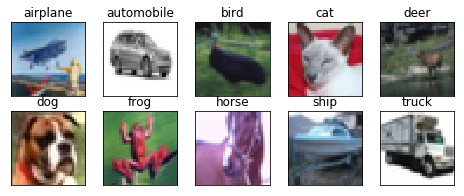

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Flatten 32x32x3 images to a 1024*3 vector for each image.
train_features = train_features.reshape(train_features.shape[0], 32, 32, 3)
test_features = test_features.reshape(test_features.shape[0], 32, 32, 3)

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Image Normalization

In [7]:
#Z-score (mean-std normalization) of images
mean = np.mean(train_features,axis=(0,1,2,3))
std = np.std(train_features,axis=(0,1,2,3))

train_features = (train_features-mean)/(std+1e-7)
test_features = (test_features-mean)/(std+1e-7)


# confirm scale of pixels
print('Train min=%.3f, max=%.3f' % (train_features.min(), train_features.max()))
print('Test min=%.3f, max=%.3f' % (test_features.min(), test_features.max()))

batch_size = 64

# create generator that centers pixel values
datagen = ImageDataGenerator(     
                              zoom_range=0.0, 
                              horizontal_flip=False,
    
                              featurewise_center=True, 
                              samplewise_center=True,
                            )

# calculate mean on training dataset
datagen.fit(train_features)


# print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# prepare an iterators to scale images
train_iterator = datagen.flow(train_features, train_labels, batch_size, shuffle=False)
test_iterator = datagen.flow(test_features, test_labels, batch_size, shuffle=False)

print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

Train min=-1.882, max=2.093
Test min=-1.882, max=2.093
Batches train=782, test=157


##Crude Network:

In [8]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(48, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(192, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` 

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)        41568     
__________

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100
390/390 [==============================] - 15s 38ms/step - loss: 1.7756 - acc: 0.3207 - val_loss: 1.3352 - val_acc: 0.5096
Epoch 2/100
390/390 [==============================] - 9s 23ms/step - loss: 1.2455 - acc: 0.5534 - val_loss: 1.0041 - val_acc: 0.6393
Epoch 3/100
390/390 [==============================] - 9s 22ms/step - loss: 1.0176 - acc: 0.6445 - val_loss: 0.8650 - val_acc: 0.7026
Epoch 4/100
390/390 [==============================] - 9s 23ms/step - loss: 0.8781 - acc: 0.6981 - val_loss: 0.7842 - val_acc: 0.7291
Epoch 5/100
390/390 [==============================] - 9s 23ms/step - loss: 0.7867 - acc: 0.7282 - val_loss: 0.7878 - val_acc: 0.7299
Epoch 6/100
390/390 [==============================] - 9s 23ms/step - loss: 0.7336 - acc: 0.7493 - val_loss: 0.7076 - val_acc: 0.7597
Epoch 7/100
390/390 [==============================] - 9s 23ms/step - loss: 0.6804 - acc: 0.7695 - val_loss: 0.6435 - val_acc: 0.7832
Epoch 8/100
390/390 [==============================] - 9s 23m

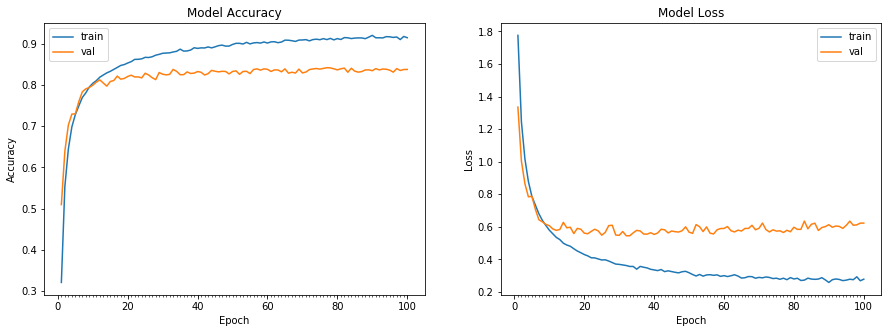

Accuracy on test data is: 83.76


In [10]:

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Part 1 - Analysis of the Crude Network:

* Total params: 1,172,410
* Batch Size = 128
* Epoch = 100
> * Validation accuracy = 84.18% 

##Part 2 - Modified Network

In [11]:
# Define the model
model = Sequential()

model.add(Conv2D(32,  kernel_size=(3, 3), use_bias=False, padding='same', input_shape=(32, 32, 3))) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(16,  kernel_size=(1, 1), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer: Max-Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(16,  kernel_size=(1, 1), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer: Max-Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Conv2D(num_classes, kernel_size=(3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Dropout(0.1))

#Layer: Flatten & activation
model.add(Flatten())
model.add(Activation('softmax'))

#Print model summary
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 64)        0         
__________

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
782/782 [==============================] - 34s 44ms/step - loss: 0.2478 - acc: 0.9085 - val_loss: 0.2709 - val_acc: 0.8986

Epoch 00001: val_acc improved from -inf to 0.89864, saving model to best_new_model.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
782/782 [==============================] - 32s 41ms/step - loss: 0.1988 - acc: 0.9243 - val_loss: 0.2182 - val_acc: 0.9159

Epoch 00002: val_acc improved from 0.89864 to 0.91590, saving model to best_new_model.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
782/782 [==============================] - 32s 41ms/step - loss: 0.1698 - acc: 0.9347 - val_loss: 0.1927 - val_acc: 0.9259

Epoch 00003: val_acc improved from 0.91590 to 0.92591, saving model to best_new_model.h5
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
782/782 [==============================] - 32s 41ms/step

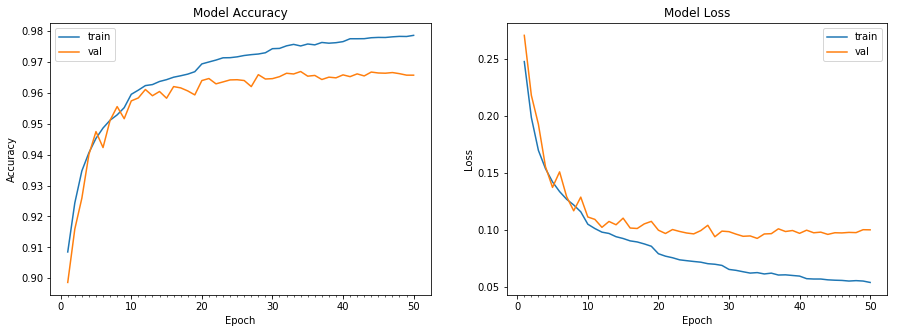

Accuracy on test data is: 81.86


In [12]:
import math
import numpy as np
from keras.optimizers import Adam, SGD, rmsprop
from keras.callbacks import LearningRateScheduler


# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
  
model.compile(optimizer= sgd,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

save_mcp = ModelCheckpoint('best_new_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# train the model
start = time.time()
# Train the model
history = model.fit_generator(train_iterator, 
                              steps_per_epoch=len(train_iterator), 
                              epochs=50, 
                              validation_data=(test_features, test_labels),
                              callbacks=[save_mcp, LearningRateScheduler(step_decay, verbose=1)], 
                              verbose=1)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(history)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Analysis of the Modified Network:

> * Total params: 388,488
> * Trainable params: 386,804
> * Non-trainable params: 1,684
>> * Validation accuracy = 96.68%

## Summary:

> In this excercise we had a crude network that had an accuracy of 84.18% for Epochs = 100. This network was re-designed  ("Modified Network")  by  removing dense layer and adding layers required to reach the receptive fields. All the dropouts were placed correctly and Image normalization was added. 


> The "Modified Network" had an improved validation accuracy of **96.68%** for a total of 50 epoch.